<a href="https://colab.research.google.com/github/smirnovaanastasia1234/Ethics-of-AI_PJ/blob/main/%D0%90%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7_%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85_%D1%80%D1%8F%D0%B4%D0%BE%D0%B2_I_%D1%87%D0%B0%D1%81%D1%82%D1%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Итоговый проект «Анализ временных рядов»**

# **Import библиотек**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [2]:
!pip install sktime[all_extras]

In [3]:
import sktime

In [4]:
from sktime.utils.plotting import plot_series
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [8]:
from sktime.forecasting.tbats import TBATS

In [9]:
!pip install numba

# **Импорт данных**

In [10]:
url = 'https://data.open-power-system-data.org/time_series/2020-10-06/'
datafile = url + 'time_series_60min_singleindex.csv'
df_all = pd.read_csv(datafile, index_col='utc_timestamp', parse_dates=True, low_memory=False)
df_all.head()

,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,BE_wind_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
utc_timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+00:00,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,734.81,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN
2015-01-01 02:00:00+00:00,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,766.64,...,1004.79,805.0,NaN,1.04,2626.0,2810.0,3.8,NaN,NaN,NaN
2015-01-01 03:00:00+00:00,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,733.13,...,983.79,803.0,NaN,1.61,2618.0,2780.0,3.8,NaN,NaN,NaN


Выберем страну Голландия

In [11]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    """Extract data for a single country"""

    # List of columns to extract
    columns = [col for col in df_all.columns if col.startswith(country_code)]

    # Extract columns and remove country codes from column labels
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)

    # Exclude years outside of specified range, if any
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]

    return df_out
df_hrly = extract_country(df_all, country_code='NL', year_min=2015, year_max=2019)
df_hrly
def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)
    # Convert from MW to GW
    df = df / 1000
    df = df.resample('D').sum(min_count=24)
    df = df.rename_axis('Date')
    df.index = df.index.strftime('%Y-%m-%d')
    return df
cols_map = {'load_actual_entsoe_transparency' : 'Consumption','wind_generation_actual' : 'Wind'}
df = transform_dataframe(df_hrly, cols_map)

#

df.to_csv('de_data.csv')
df.head()

,Consumption,Wind
Date,,
2015-01-01,246.812,45.62
2015-01-02,286.350,55.46
2015-01-03,310.086,NaN
2015-01-04,300.702,NaN
2015-01-05,377.177,NaN


# **EDA - Разведывательный анализ данных**

In [12]:
df.info() # информация о данных в датафрейме: сколько строк, какие данные в столбцах, сколько пропущенных значений (Nan-values)

<class 'pandas.core.frame.DataFrame'>
Index: 1826 entries, 2015-01-01 to 2019-12-31
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Consumption  1826 non-null   float64
 1   Wind         1714 non-null   float64
dtypes: float64(2)
memory usage: 42.8+ KB


In [13]:
# определим категориальные и численные столбцы
cat_columns = []
num_columns = []

for column_name in df.columns:
    if (df[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  [] 
 Число столблцов =  0
Числовые данные:	  ['Consumption', 'Wind'] 
 Число столблцов =  2


In [14]:
df.describe() # выводим информацию о числовых столбцах

,Consumption,Wind
count,1826.000000,1714.000000
mean,303.511351,24.648586
std,35.268803,18.216001
min,191.961000,0.600000
25%,276.349500,9.913750
50%,308.167500,19.776500
75%,326.512500,36.409500
max,377.914000,87.157000


In [15]:
path_ts = 'de_data.csv'

df = pd.read_csv(path_ts, parse_dates=['Date'], index_col="Date")

df.sample(5, random_state=0)

,Consumption,Wind
Date,,
2017-03-04,299.152,24.077
2017-02-28,342.720,74.358
2015-04-29,274.775,23.419
2015-11-15,244.919,60.238
2017-06-10,264.678,15.045


Данные обработанные в форме дат DateTimeIndex позволяют работать с индексом как с датой

In [16]:
print(df.index.day)
print(df.index.weekday)
print(df.index.year)

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
           dtype='int64', name='Date', length=1826)
Int64Index([3, 4, 5, 6, 0, 1, 2, 3, 4, 5,
            ...
            6, 0, 1, 2, 3, 4, 5, 6, 0, 1],
           dtype='int64', name='Date', length=1826)
Int64Index([2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
            ...
            2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019, 2019],
           dtype='int64', name='Date', length=1826)


In [17]:
df.dtypes

Consumption    float64
Wind           float64
dtype: object

 Посмотрим сколько у нас NaN значений. Для этого можно использовать или метод isnull или isna.

In [18]:
df.isna().sum()

Consumption      0
Wind           112
dtype: int64

In [19]:
df.fillna(0, inplace=True)
df.head(3)

,Consumption,Wind
Date,,
2015-01-01,246.812,45.62
2015-01-02,286.350,55.46
2015-01-03,310.086,0.00


Размер набора данных

In [20]:
print(df.shape)

(1826, 2)


# **Визуализация временного ряда**

<Axes: xlabel='Date'>

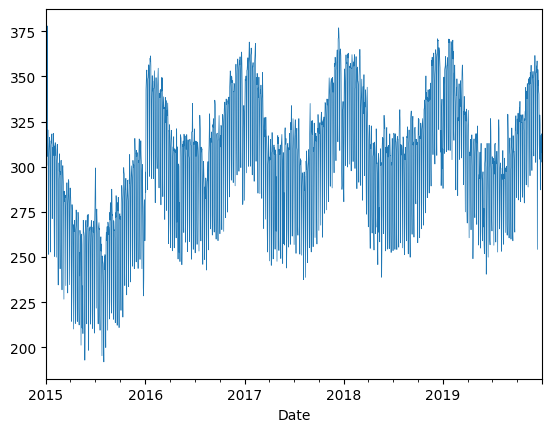

In [21]:
df['Consumption'].plot(linewidth=0.5)

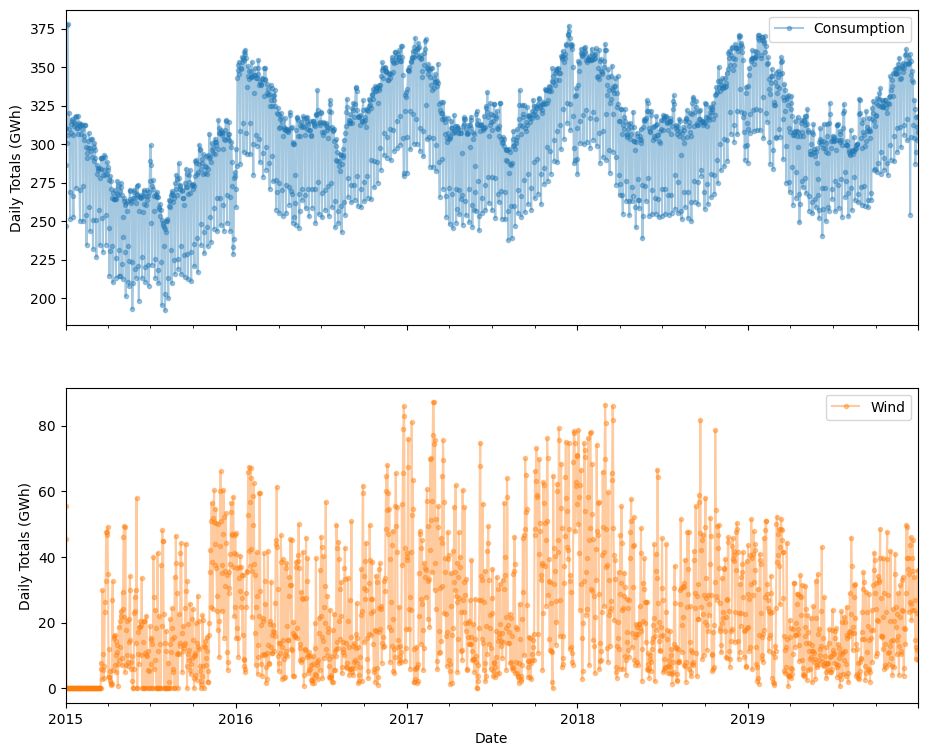

In [22]:
cols_plot = ['Consumption','Wind']
axes = df[cols_plot].plot(marker='.', alpha=0.4, linestyle='-', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

# **1. Анализ общего потребления**

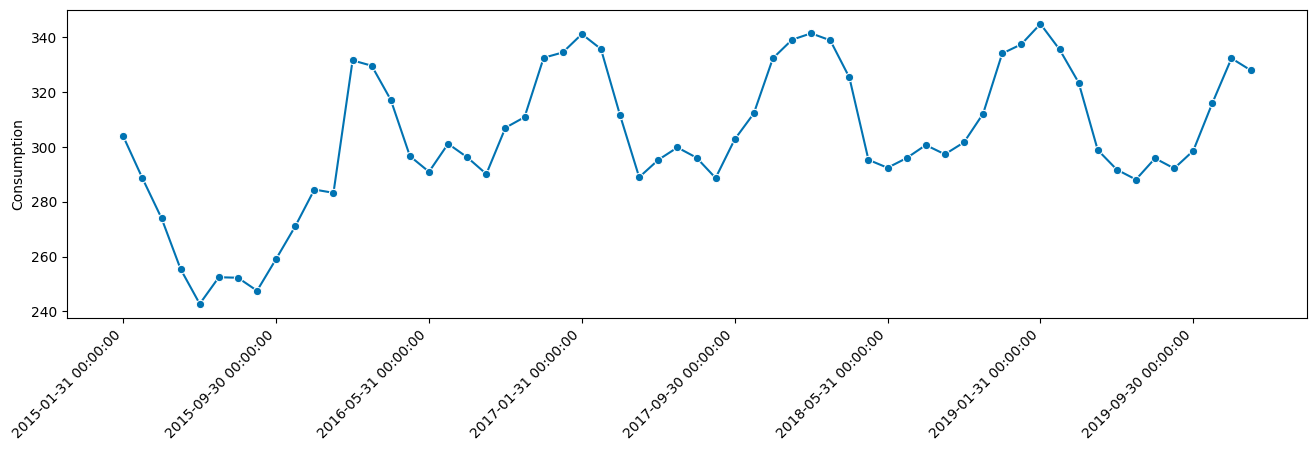

In [23]:
df_monthly = df['Consumption'].resample('M').mean()
plot_series(df_monthly)
plt.xticks(rotation=45, ha='right');

Посмотрим на скользящее среднее с шагом 30 и 365 дней.

<Axes: xlabel='Date'>

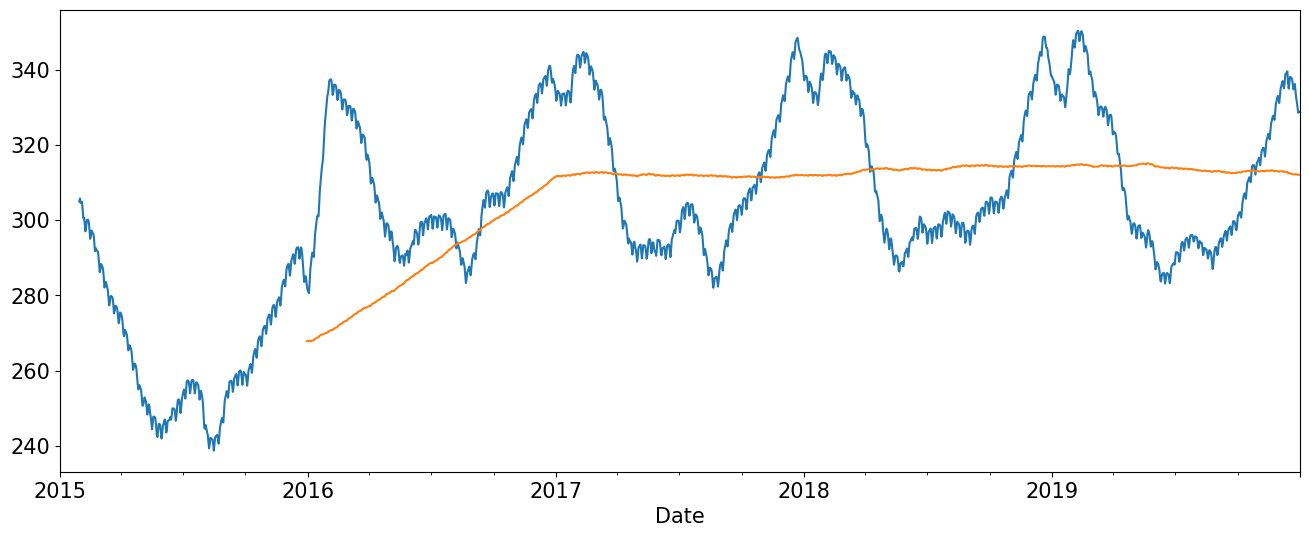

In [24]:
plt.rc('figure',figsize=(16,6))
plt.rc('font',size=15)
# create moving-averages
df['Consumption'].rolling(30).mean().plot()
df['Consumption'].rolling(365).mean().plot()

В ряде наблюдается сезонность.  в Период с 2015 по 2016 наблюдается аномалия. Проверим гипотезу.Для этого используем скользящее среднее.

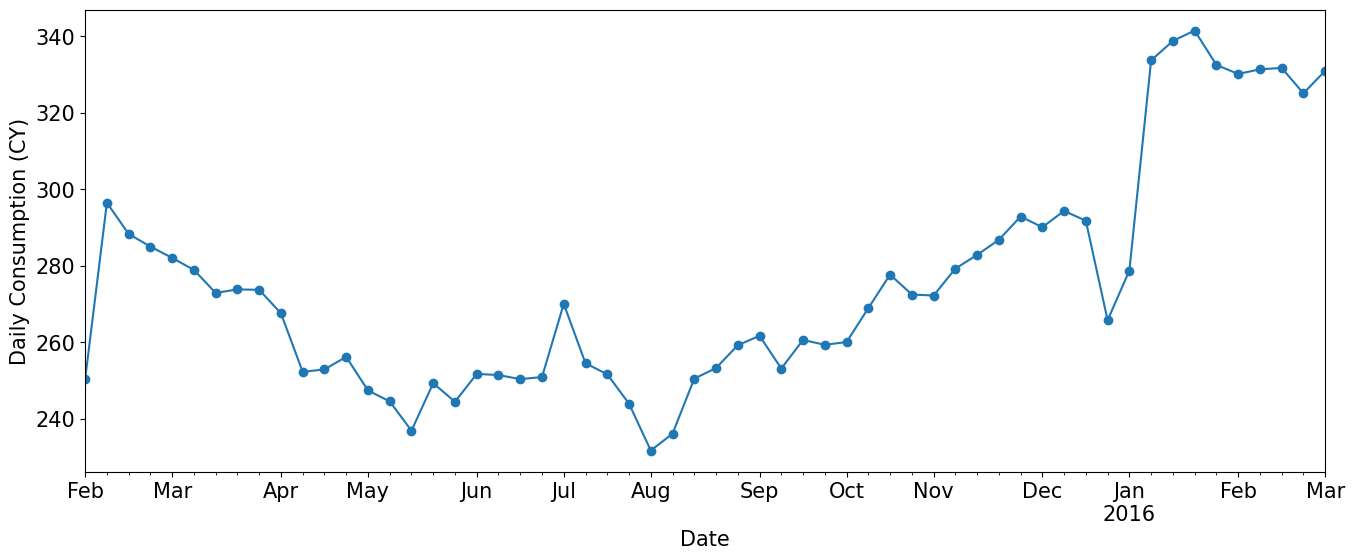

In [25]:
ax = df.loc['2015-02':'2016-02', 'Consumption'].\
    resample('W').mean().plot(marker='o', linestyle='-',linewidth=1.5)
ax.set_ylabel('Daily Consumption (CY)')
plt.show()

Визуализируем тренд, сезонность и шум в общем потреблении электроэнергии:

Тренд - плавное долгосрочное изменение уровня ряда

Сезонность  – циклические изменения уровня ряда с постоянным периодом

Ошибка /шум  – непрогнозируемая случайная компонента ряда

проверим тренд при помощи построения BBox

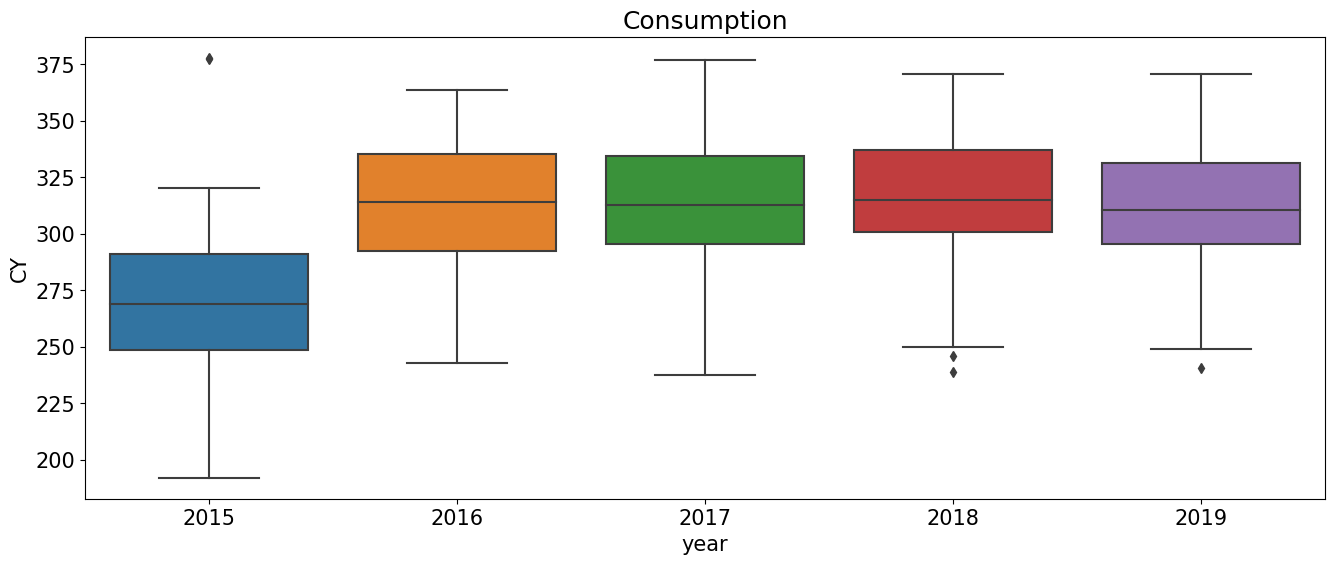

In [26]:
ax = sns.boxplot(data=df, x=df.index.year, y='Consumption')
ax.set_ylabel('CY')
ax.set_xlabel('year')
ax.set_title('Consumption')
plt.show()

Явно выдяляются данные 2015 года. 2016-2019 пректически без изменений

In [27]:
def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):
        df_ = df_.append(df.loc[df.index.month == month])
    return df_

In [30]:
def to_segments(df, column, size = 24):
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)
winter = to_segments(split_by_month(df, [1,2, 12]), 'Consumption', size = 24)
summer = to_segments(split_by_month(df, [6, 7, 8]), 'Consumption', size = 24)
autumn = to_segments(split_by_month(df, [9,10,11]), 'Consumption', size = 24)
spring = to_segments(split_by_month(df, [3, 4, 5]), 'Consumption', size = 24)
print(winter.shape, summer.shape, autumn.shape, spring.shape)

(17, 24) (18, 24) (17, 24) (18, 24)


<ipython-input-27-ce19d65da6fb>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ = df_.append(df.loc[df.index.month == month])
<ipython-input-27-ce19d65da6fb>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ = df_.append(df.loc[df.index.month == month])
<ipython-input-27-ce19d65da6fb>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ = df_.append(df.loc[df.index.month == month])
<ipython-input-27-ce19d65da6fb>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_ = df_.append(df.loc[df.index.month == month])
<ipython-input-27-ce19d65da6fb>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas 

Теперь мы создали 4 класса. Давайте посмотрим, как выглядят их примеры:

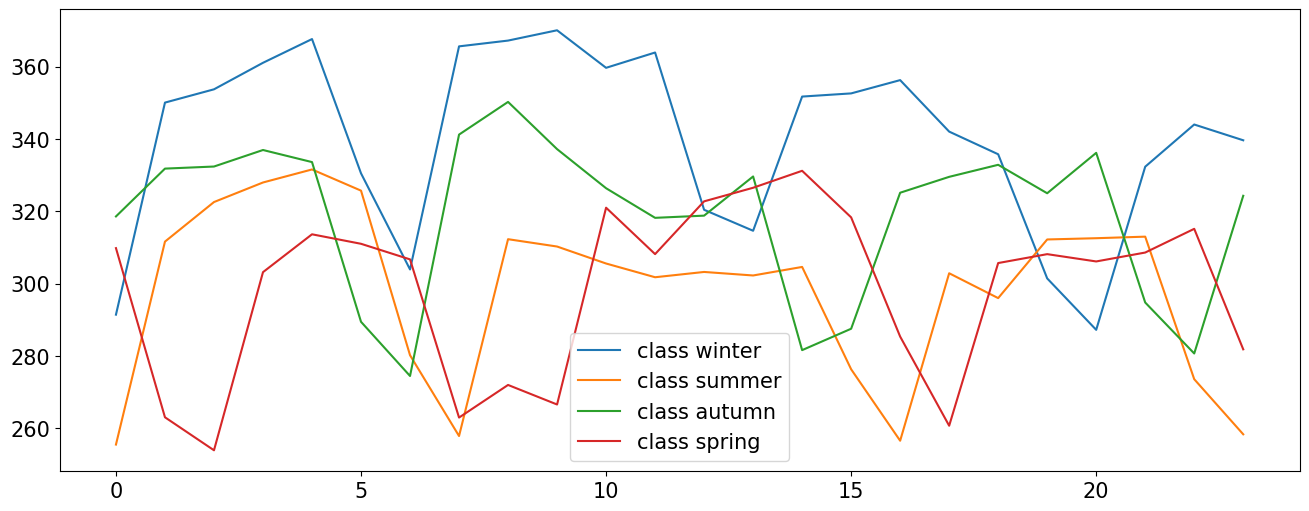

In [29]:
plt.figure()
day = 10
for i,(c,d) in enumerate(zip([winter,summer,autumn,spring],['winter','summer','autumn','spring'])):
    plt.plot(c[day], label="class " + str(d))
plt.legend(loc="best")
plt.show()
plt.close()

проверим наличие сезонных составляющих

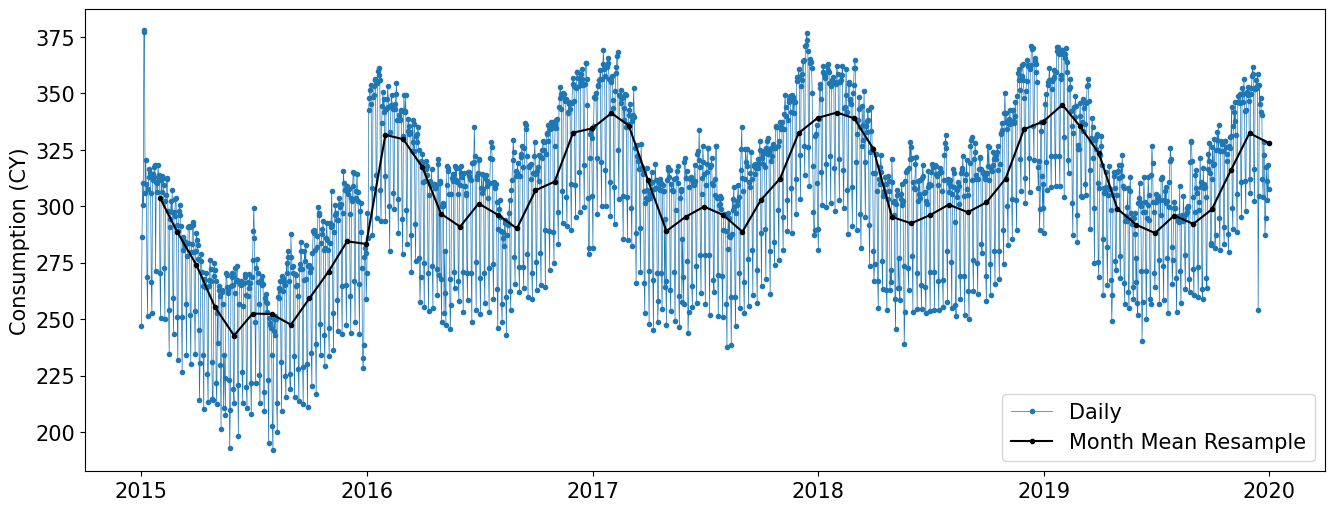

In [31]:
start, end = '2015-01', '2019-12'

fig, ax = plt.subplots()
ax.plot(df.loc[start:end, 'Consumption'],marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(df.resample('M').mean().loc[start:end, 'Consumption'], marker='o', markersize=3, linestyle='-', label='Month Mean Resample', color='k')
ax.set_ylabel('Consumption (CY)')
ax.legend();

в 2015 году данные данные зашумлены. данные за период 2016-2020 носят сезонный характер

# **2. Сравнение методов предсказаний значений ВР**

## Библиотека SKTime

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from prophet import Prophet

In [33]:
from sktime.datasets import load_basic_motions

In [34]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

In [35]:
y = df['Consumption'].asfreq('7d')
y.head()

Date
2015-01-01    246.812
2015-01-08    320.345
2015-01-15    314.668
2015-01-22    317.489
2015-01-29    313.642
Freq: 7D, Name: Consumption, dtype: float64

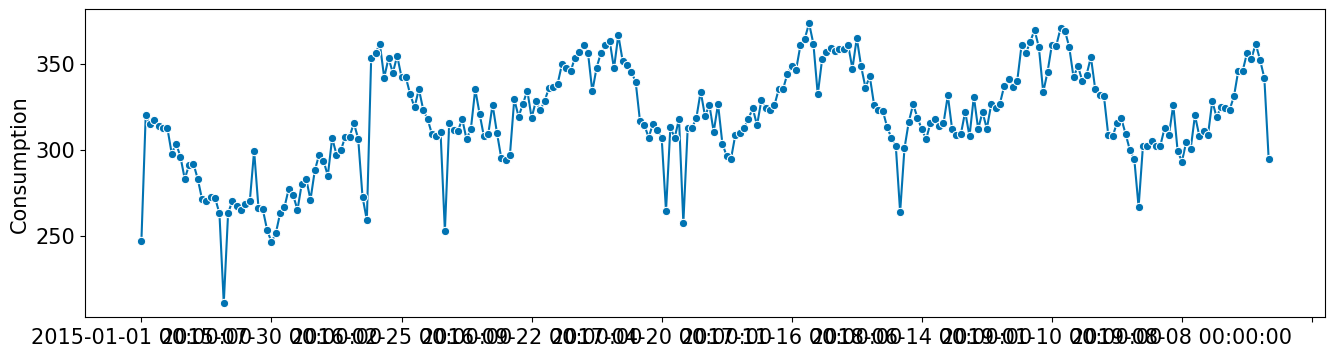

In [36]:
sktime.utils.plotting.plot_series(y);

Для разделения данных воспользуемся функцией temporal_train_test_split, которая позволяет адаптировать разделение данных не разрушая временные зависимости в данных.

Check splitted data size: Train: 144, Test: 117


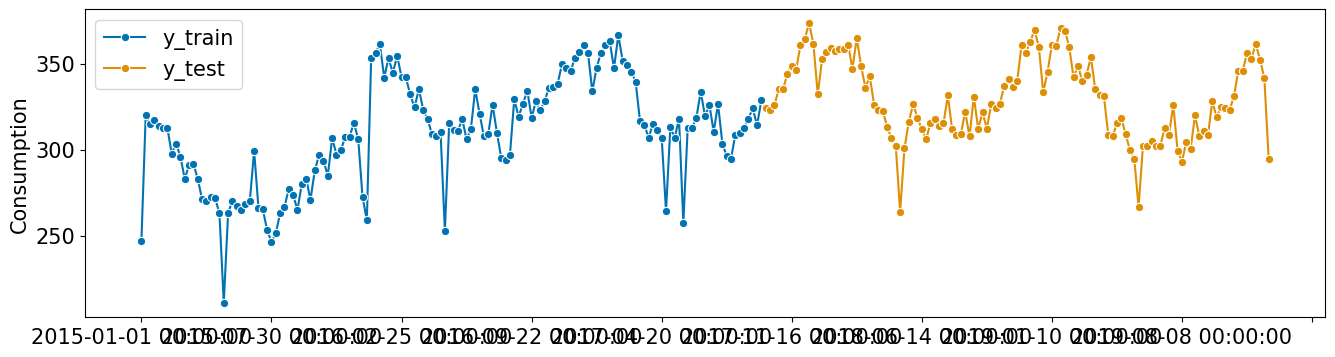

In [37]:
TEST_SIZE = int(0.45*y.size)

y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)

print(f'Check splitted data size: Train: {y_train.shape[0]}, Test: {y_test.shape[0]}')

sktime.utils.plotting.plot_series(y_train, y_test, labels=["y_train", "y_test"]);

Прогноз основан на наивных предположениях о продолжении прошлых тенденций. Построим модели с 3-я стратегиями: last, mean, drift и посмотрим, какая из моделей лучше себя проявит.

In [39]:
smape = MeanAbsolutePercentageError(symmetric = True)

sMAPE = 0.058


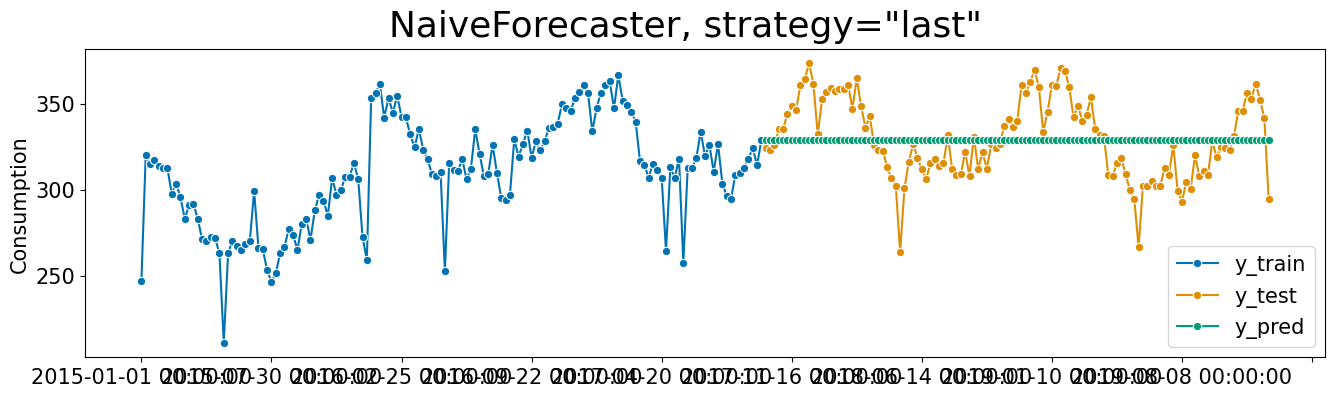

In [40]:
# ГОРИЗОНТ
#fh = np.arange(y_test.size) + 1
fh = ForecastingHorizon(y_test.index, is_relative=False)

# ПРЕДСКАЗАТЕЛЬ
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)

# ПРЕДСКАЗАНИЕ
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred,title = 'NaiveForecaster, strategy="last"', labels=["y_train", "y_test", "y_pred"])

# ОШИБКА
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Также давайте попробуем оценить точность наивного сезонного предсказания.

/usr/local/lib/python3.10/dist-packages/sktime/forecasting/naive.py:170: UserWarning: For the `drift` strategy, the `sp` value will be ignored.
  warn(


sMAPE = 0.113


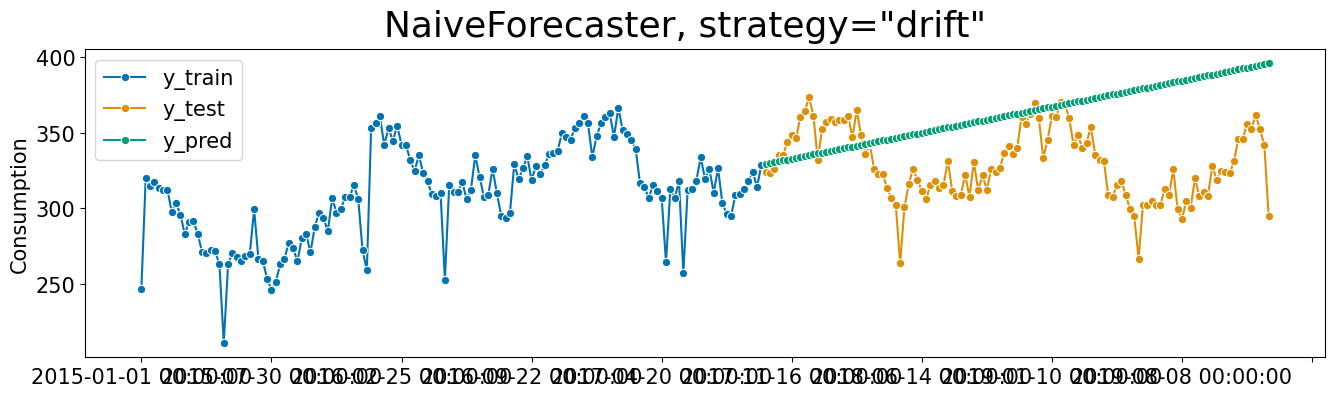

In [41]:
SEASON = 52

forecaster = NaiveForecaster(strategy="drift", sp=SEASON)
forecaster.fit(y_train)
y_pred_drift = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred_drift, title = 'NaiveForecaster, strategy="drift"', labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred_drift.values, y_test.values):.3f}')

sMAPE = 0.063


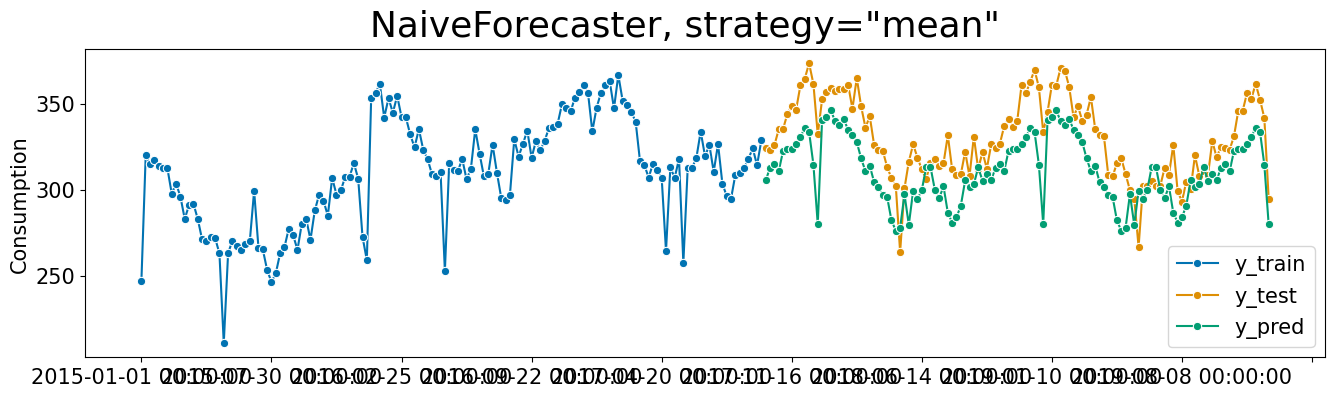

In [42]:
forecaster = NaiveForecaster(strategy="mean", sp=SEASON)
forecaster.fit(y_train)
y_pred_mean = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred_mean, title = 'NaiveForecaster, strategy="mean"', labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred_mean.values, y_test.values):.3f}')

В нашем случае лучший результат показала стратегия last - sMAPE: 0.058

Семейство методов на основе экспоненциального сглаживания

### Simple Exponential Smoothing.

Для начала оценим точность наиболее простого варианта Simple Exponential Smoothing.

Точность в предыдущих случаях оставляла желать лучшего. Посмотрим на работу более сложных методов экспоненциального сглаживания.

In [43]:
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)

In [44]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

sMAPE = 0.059


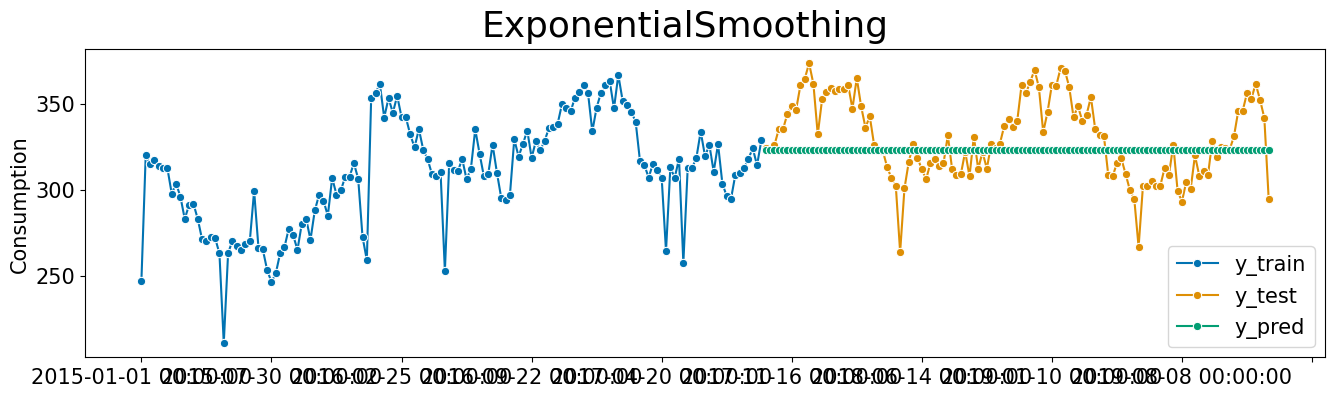

In [45]:
forecaster = ExponentialSmoothing()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred,title = 'ExponentialSmoothing', labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')
sMAPE = 0.066

sMAPE = 0.072


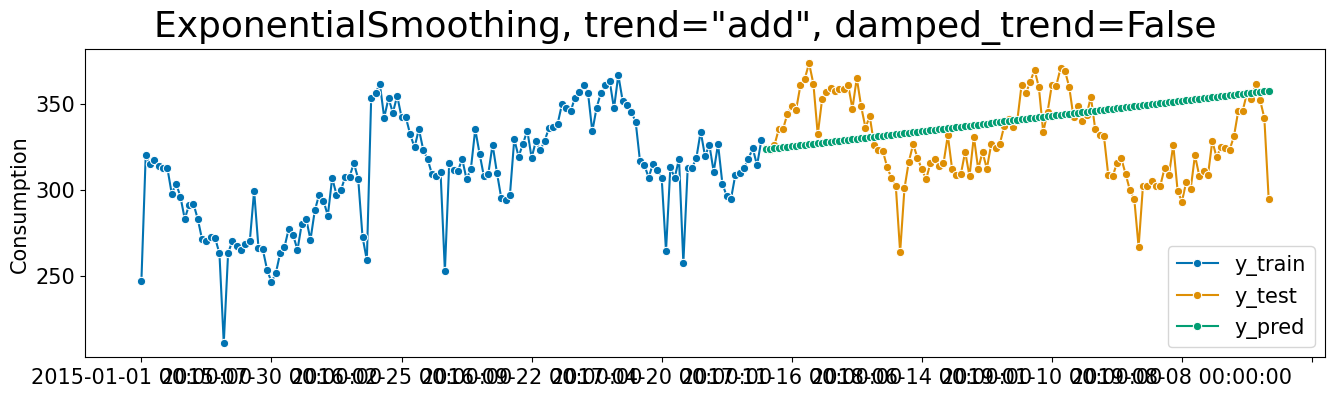

In [46]:
ses_trend_add = ExponentialSmoothing(trend="add", damped_trend=False,  sp=SEASON)
ses_trend_add.fit(y_train)
y_pred_ses_trend_add = ses_trend_add.predict(fh)

plot_series(y_train, y_test, y_pred_ses_trend_add, title = 'ExponentialSmoothing, trend="add", damped_trend=False', labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred_ses_trend_add.values, y_test.values):.3f}')

sMAPE = 0.080


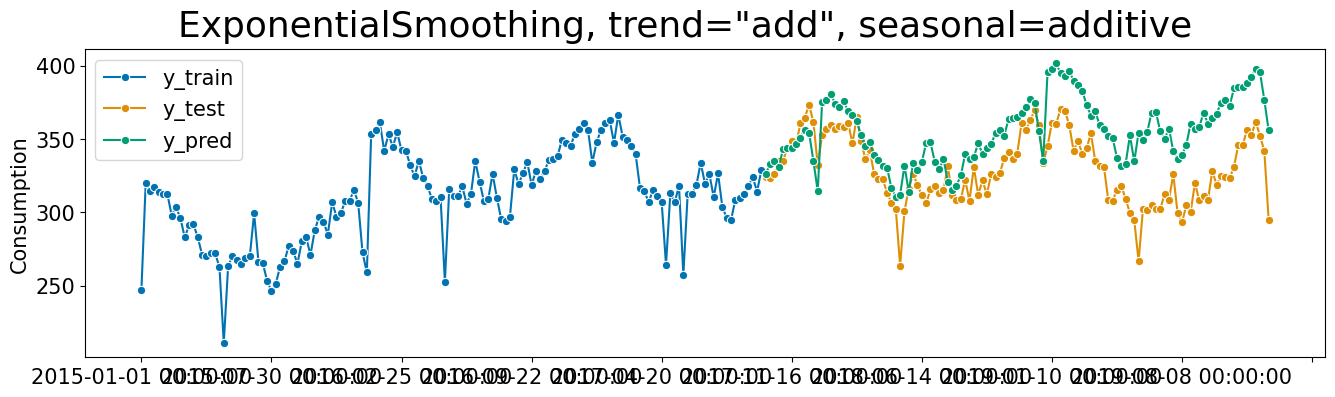

In [47]:
holt_winter = ExponentialSmoothing(trend="add", seasonal="additive", sp=SEASON)
holt_winter.fit(y_train)
y_pred_holt_winter = holt_winter.predict(fh)

plot_series(y_train, y_test, y_pred_holt_winter, title = 'ExponentialSmoothing, trend="add", seasonal=additive', labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred_holt_winter.values, y_test.values):.3f}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


sMAPE = 0.079


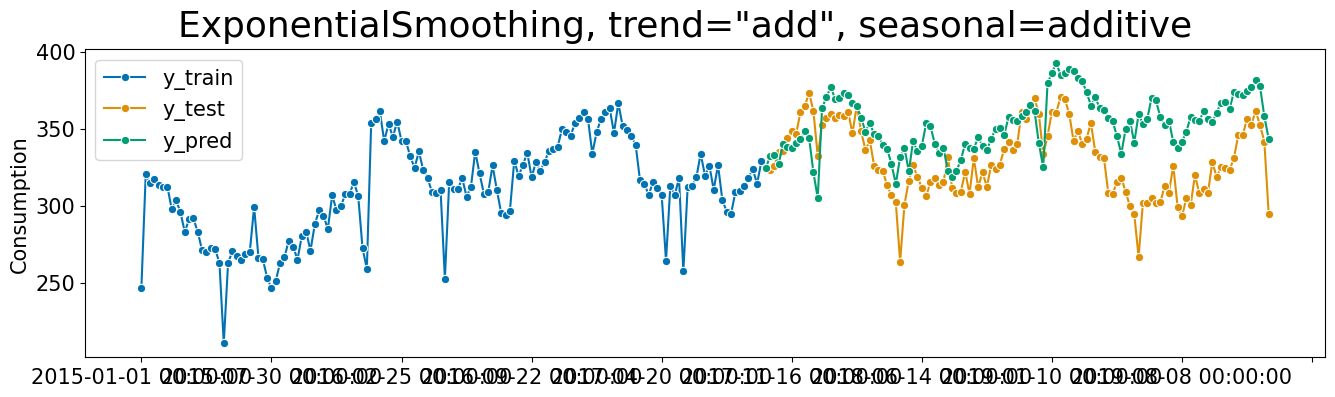

In [48]:
holt_winter_add_boxcox  = ExponentialSmoothing(trend="add", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_add_boxcox.fit(y_train)
y_pred_holt_winter_add_boxcox = holt_winter_add_boxcox.predict(fh)

plot_series(y_train, y_test, y_pred_holt_winter_add_boxcox, title = 'ExponentialSmoothing, trend="add", seasonal=additive', labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred_holt_winter_add_boxcox, y_test.values):.3f}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


sMAPE = 0.096


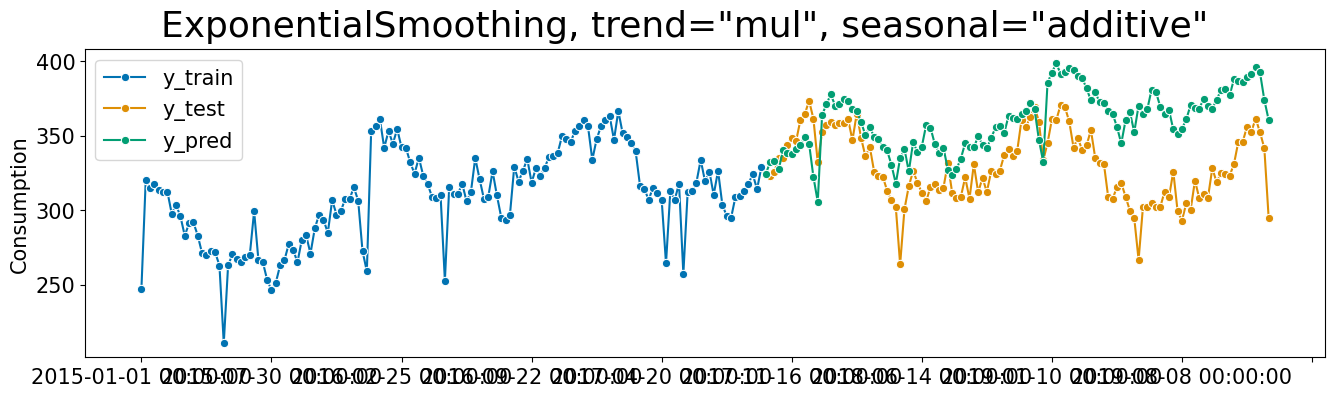

In [49]:
holt_winter_mul_boxcox  = ExponentialSmoothing(trend="mul", seasonal="additive", use_boxcox =True, sp=SEASON)
holt_winter_mul_boxcox.fit(y_train)
y_pred_holt_winter_mul_boxcox = holt_winter_mul_boxcox.predict(fh)

plot_series(y_train, y_test, y_pred_holt_winter_mul_boxcox, title = 'ExponentialSmoothing, trend="mul", seasonal="additive"', labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred_holt_winter_mul_boxcox, y_test.values):.3f}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


sMAPE = 0.082


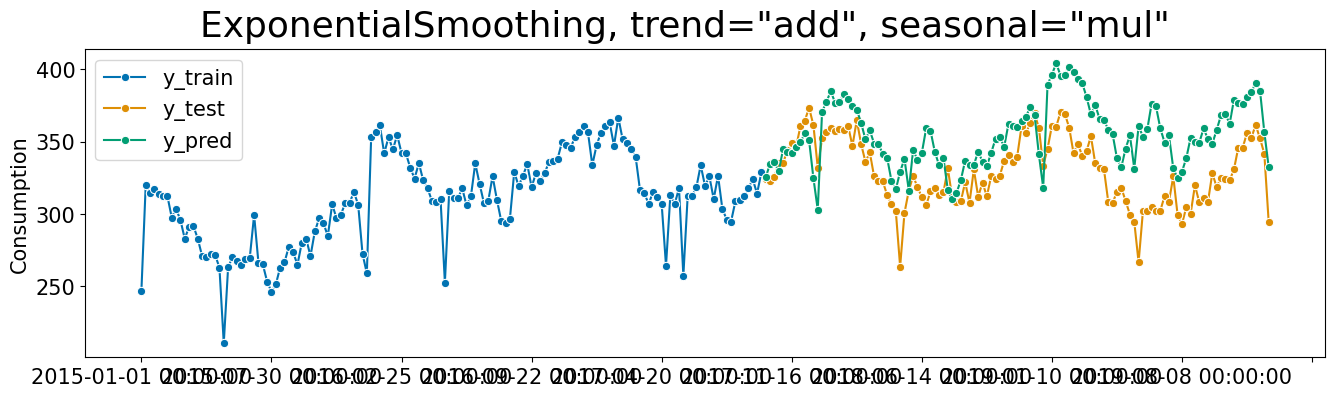

In [51]:
holt_winter_sadd_boxcox = ExponentialSmoothing(trend="add", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_sadd_boxcox .fit(y_train)
y_pred_holt_holt_winter_sadd_boxcox  = holt_winter_sadd_boxcox .predict(fh)

plot_series(y_train, y_test, y_pred_holt_holt_winter_sadd_boxcox , title = 'ExponentialSmoothing, trend="add", seasonal="mul"', labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred_holt_holt_winter_sadd_boxcox , y_test.values):.3f}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


sMAPE = 0.135


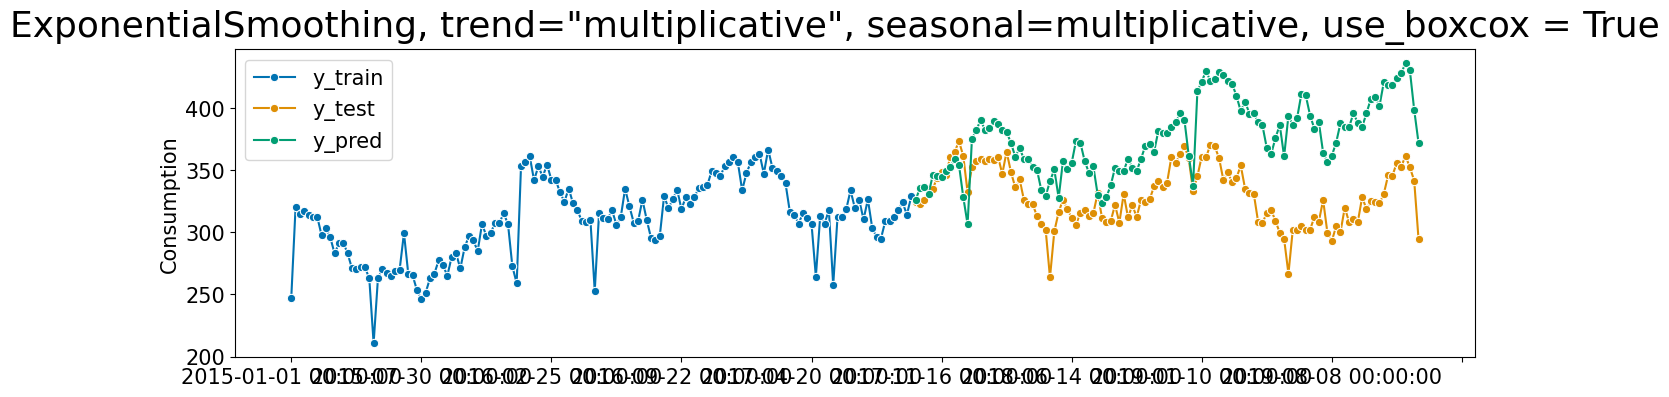

In [52]:
ses_trend_mul = ExponentialSmoothing(trend="multiplicative", seasonal='multiplicative', use_boxcox = True,  sp=SEASON)
ses_trend_mul.fit(y_train)
y_pred_ses_trend_mul = ses_trend_mul.predict(fh)

plot_series(y_train, y_test, y_pred_ses_trend_mul, title = 'ExponentialSmoothing, trend="multiplicative", seasonal=multiplicative, use_boxcox = True', labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred_ses_trend_mul.values, y_test.values):.3f}')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:455: UserWarning: y_pred and y_true do not have the same row index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(
/usr/local/lib/python3.10/dist-packages/sktime/performance_metrics/forecasting/_classes.py:467: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


sMAPE = 0.135


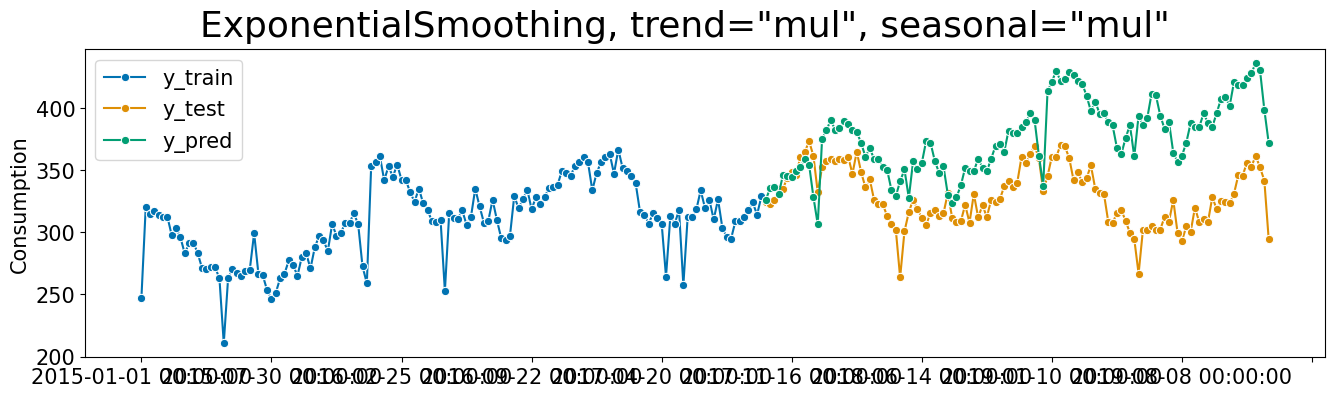

In [53]:
holt_winter_smul_boxcox = ExponentialSmoothing(trend="mul", seasonal="mul", use_boxcox =True, sp=SEASON)
holt_winter_smul_boxcox .fit(y_train)
y_pred_holt_winter_smul_boxcox  = holt_winter_smul_boxcox .predict(fh)

plot_series(y_train, y_test, y_pred_holt_winter_smul_boxcox, title = 'ExponentialSmoothing, trend="mul", seasonal="mul"', labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred_holt_winter_smul_boxcox , y_test.values):.3f}')

Метод экспоненциального сглаживания не сильно повлиял на улучшение показателей

### AutoETS

sMAPE = 0.033


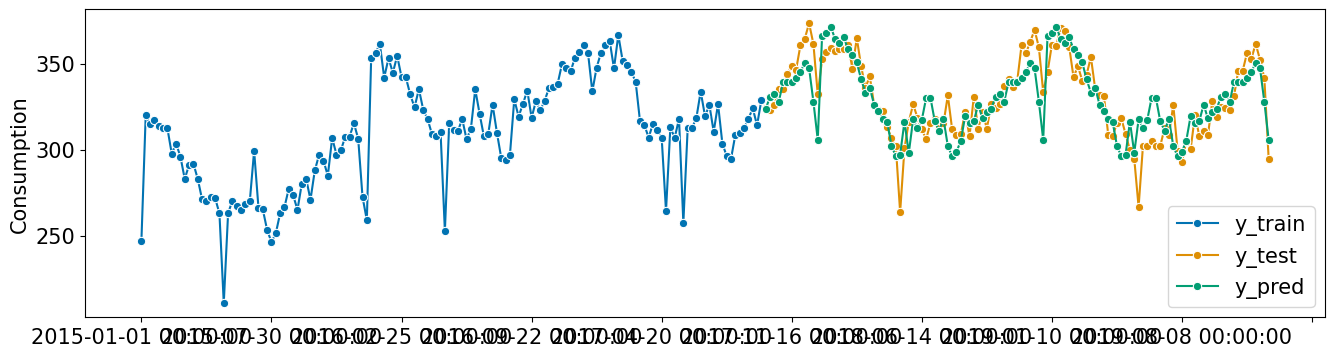

In [54]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=SEASON, n_jobs=-1)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Модель с автоматическим подбором параметров улучшила предыдущий результат (sMAPE = 0.033)

### TBATS

sMAPE = 0.034


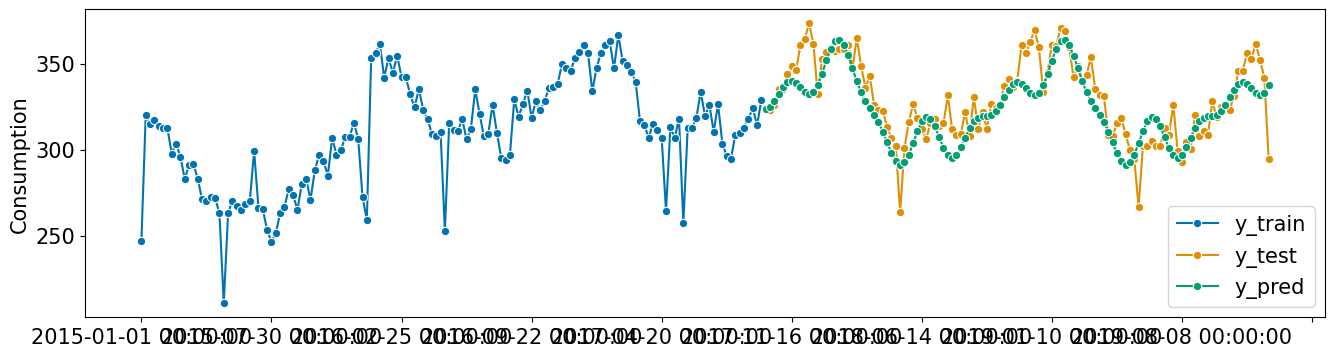

In [55]:
forecaster = TBATS(
    use_box_cox=True,
    use_trend=True,
    use_damped_trend=True,
    sp=SEASON,
    use_arma_errors=True,
    n_jobs=-1)

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

### Prophet

In [57]:
from sktime.forecasting.fbprophet import Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm09vcd7l/h_hcr1ff.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpm09vcd7l/9o2tjhmm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42127', 'data', 'file=/tmp/tmpm09vcd7l/h_hcr1ff.json', 'init=/tmp/tmpm09vcd7l/9o2tjhmm.json', 'output', 'file=/tmp/tmpm09vcd7l/prophet_modelcjq04me_/prophet_model-20240108183939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:39:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:39:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


sMAPE = 0.040


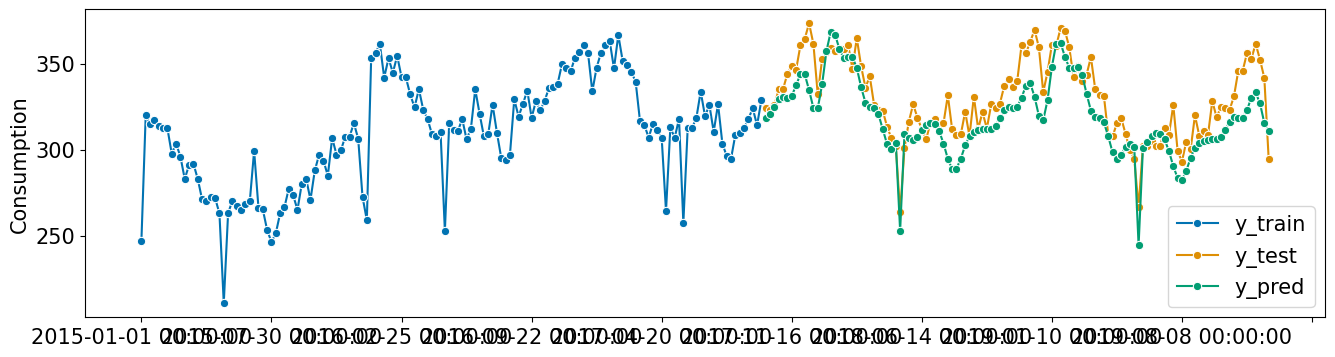

In [58]:
forecaster = Prophet(
                    seasonality_mode='additive',
                    n_changepoints=int(len(y_train) / 4),
                    add_country_holidays={'country_name': 'Germany'},
                    yearly_seasonality=True)

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

Лучший результат у модели с автоматическим подбором параметров улучшила предыдущий результат (sMAPE = 0.033)